In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sympy
from sympy import symbols, sympify, lambdify, compose, I, pi, log, exp, simplify

In [20]:
import warnings

# Desactivar la advertencia de desbordamiento en potencias
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [21]:

# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

        Poblacion = self.Simplificador(Poblacion)
        Chi = []
        x = symbols('x', real=True)
        expresiones_sympy = [sympify(exp) for exp in Poblacion]
        funciones_python = [lambdify(x, expresion, 'numpy') for expresion in expresiones_sympy]

        indices = []

        for n , funcion in enumerate(funciones_python):
            f = funcion(z)
            chi_value = np.sum(np.square((f - H)/desv))

            if not np.isinf(chi_value) and not np.isnan(chi_value):
                Chi.append(chi_value)
                indices.append(n)
                
        indices = np.array(indices)
        Poblacion = np.array(Poblacion)

        poblacion_nueva = Poblacion[indices].tolist()

        return np.array(Chi), poblacion_nueva

In [22]:
class GA:
    def __init__(self, num_poblacion_inicial, poblacion_base, operaciones_base):
        self.poblacion_base = poblacion_base
        self.operaciones_base = operaciones_base
        self.numero_inicial = num_poblacion_inicial       

    def Simplificador(self, poblacion):
        x = symbols('x')
        expresiones_simplificadas = [simplify(expresion) for expresion in poblacion]
        return expresiones_simplificadas

    def Composicion(self, f1, f2):
        x = symbols('x')
        expresiones = [f1, f2]
        expresiones_sympy = [sympify(exp) for exp in expresiones] 
        f1 = expresiones_sympy[0]
        f2 = expresiones_sympy[1]
        # Se componen expresiones
        composicion = f1.subs(x, f2)
        return str(composicion)
    
    def Creador(self):
        Poblacion = np.zeros(self.numero_inicial, dtype=object)
        for n in range(0, self.numero_inicial):
            f1 = random.choice(self.poblacion_base)
            f2  = random.choice(self.poblacion_base)
            operador = random.choice(self.operaciones_base)

            if operador == 'comp':
                kid = self.Composicion(f1, f2)
                Poblacion[n] = kid
            else:
                kid= f"{f1} {operador} {f2}"
                Poblacion[n] = kid
        
        return Poblacion
    
    def Reproductor(self, Funciones_seleccionadas, porcentaje_mutacion, cantidad_hijos): 
        
        combinados = np.zeros(len(Funciones_seleccionadas)*cantidad_hijos, dtype=object)

        for j, funcion in enumerate(Funciones_seleccionadas):
            operaciones_para_combinacion = [random.choice(self.operaciones_base) for i in range(cantidad_hijos)]
            funciones_a_combinar = [random.choice(Funciones_seleccionadas) for i in range(cantidad_hijos)]
            for n in range(0, len(operaciones_para_combinacion)):
                if operaciones_para_combinacion[n] == 'comp':
                    kid = self.Composicion(funcion, funciones_a_combinar[n])
                    combinados[n + (cantidad_hijos)*j] = kid
                else: 
                    kid = f"({funcion}) {operaciones_para_combinacion[n]} ({funciones_a_combinar[n]})"
                    combinados[n + (cantidad_hijos)*j] = kid        

        # EMPIEZA MUTACION
        num_mutacion = int(len(combinados)*(porcentaje_mutacion/100))
        funciones_a_mutar = []
        mutaciones = np.zeros(num_mutacion, dtype=object)

        for n in range(0, num_mutacion): 
            expresion_m = random.choice(combinados)
            funciones_a_mutar.append(expresion_m)
            operacion = random.choice(self.operaciones_base)
            expresion2 = random.choice(self.poblacion_base)
            coeficiente = random.random()
            operacion2 = random.choice(['**', '*'])

            if operacion == 'comp':
                mutado = self.Composicion(expresion_m, expresion2)
                mutaciones[n] = mutado
            else: 
                mutado = f"{coeficiente} {operacion2} {expresion_m} {operacion} {expresion2}"
                mutaciones[n] = mutado

        mutaciones = mutaciones.tolist()
        indices_no_mutados = np.array([i for i, elem in enumerate(combinados) if elem not in funciones_a_mutar])
        funciones_sin_mutar = combinados[indices_no_mutados].tolist()
        mutaciones += funciones_sin_mutar 

        
        return mutaciones
    
    def Calculador_Chi(self, Poblacion, z, H, desv):
        x = symbols('x', real=True)
        expresiones_sympy = [sympify(exp) for exp in Poblacion]
        funciones_python = [lambdify(x, expresion, 'numpy') for expresion in expresiones_sympy]

        Chi = np.empty(0)
        indices = np.empty(0, dtype=int)

        for n, funcion in enumerate(funciones_python):
            f = funcion(z)
            chi_value = np.sum(np.square((f - H) / desv))

            if not np.isinf(chi_value) and not np.isnan(chi_value):
                Chi = np.append(Chi, chi_value)
                indices = np.append(indices, n)

        Poblacion = np.array(Poblacion)

        poblacion_nueva = Poblacion[indices].tolist()

        return Chi, poblacion_nueva
    
    def Seleccionador(self, mutaciones, Chi, porcentaje_seleccion):

        seleccion = np.percentile(Chi, porcentaje_seleccion)
        
        print('El chi menor fue: ' + str(min(Chi)))
        print('El chi MAYOR fue: ' + str(max(Chi)))
        print('La seleccion fue: ' + str(seleccion))

        Chi_seleccionados = Chi[Chi <= seleccion]
        indices = np.where(Chi <= seleccion)[0]
        funciones_seleccionadas = [mutaciones[i] for i in range(len(Chi)) if Chi[i] <= seleccion]
        funciones_NO_seleccionadas = [mutaciones[i] for i in range(len(Chi)) if not Chi[i] <= seleccion]

        porcentaje1 = random.random()

        porcentaje2 = random.random()

        if porcentaje1 < porcentaje2:
            No_aptos = [random.choice(funciones_NO_seleccionadas)]
        else:
            No_aptos = []


        combined_data = list(zip(Chi_seleccionados, funciones_seleccionadas))

        # Ordena la lista combinada por los elementos de x
        sorted_combined_data = sorted(combined_data, key=lambda pair: pair[0])

        # Desempaqueta los resultados ordenados
        Chis, funciones = zip(*sorted_combined_data)

        Funciones_seleccionadas = list(funciones) + No_aptos

        Chi_menor = min(Chis)

        return Funciones_seleccionadas, Chi_menor


In [23]:
A = GA(num_poblacion_inicial=5, poblacion_base = ['x', '(x)**x'], operaciones_base = ['*', '+', '-', '/', 'comp'])

B = A.Reproductor(['x', '(x)**x'], 50, 6)

C = A.Calculador_Chi(B, z, H, desv)

print(C[1])

D = A.Seleccionador(C[1], C[0], 20)

print(D[0])

['0.5173635190210845 ** (x) * ((x)**x) - (x)**x', '0.06926741763197175 ** (x) - (x) + x', '0.5298060840780289 ** (x) - (x) / x', '0.14868511180704647 * ((x)**x) - (x) - x', '0.26347590577310964 ** ((x)**x) / ((x)**x) - x', '0.028469499095239548 ** ((x)**x) + ((x)**x) * (x)**x', '(x) + ((x)**x)', '(x) / ((x)**x)', '(x) + (x)', 'x', '(x**x)**(x**x)', '((x)**x) * (x)', '((x)**x) - ((x)**x)']
El chi menor fue: 3893.405157535433
El chi MAYOR fue: 87552580963.57848
La seleccion fue: 4221.739280048202
['0.028469499095239548 ** ((x)**x) + ((x)**x) * (x)**x', '((x)**x) * (x)', '(x) + ((x)**x)', '0.14868511180704647 * ((x)**x) - (x) - x']


In [24]:
class Generaciones:
    def __init__(self, num_poblacion_inicial, poblacion_base, operaciones_base):
        self.num = num_poblacion_inicial
        self.poblacion_base = poblacion_base
        self.operaciones_base = operaciones_base

    
    def Iteracion(self, num_generaciones, porcentaje_seleccion, porcentaje_mutacion, z, H, desv, numero_hijos):

        Generaciones = []
        Chi_menor = []

        A = GA(num_poblacion_inicial = self.num, poblacion_base=self.poblacion_base, operaciones_base=self.operaciones_base)

        for n in range(0, num_generaciones):
            print('Número de Generación:' +str(n))
            if n == 0:
                C= A.Creador()
                R = A.Reproductor(C, porcentaje_mutacion, numero_hijos)
                #R_s = A.Simplificador(R)
                Cal = A.Calculador_Chi(R, z, H, desv)
                S = A.Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
                Generaciones.append(S[0])
                Chi_menor.append(S[1])
                print('LONGITUD GENERACION INCIAL: ' + str(len(Generaciones[0])))

            else:
                R = A.Reproductor(Generaciones[n-1], porcentaje_mutacion, numero_hijos)
                print('Se reproducen')
                #R_s = A.Simplificador(R)
                Cal = A.Calculador_Chi(R, z, H, desv)
                print('Se calcula Chi')
                S = A.Seleccionador(Cal[1], Cal[0], porcentaje_seleccion)
                print('Seleccion')
                Generaciones.append(S[0])
                Chi_menor.append(S[1])
                if Chi_menor[n] < 50:
                    print('Se corta por Chi menor')
                    break
                print('LONGITUD GENERACION: ' + str(len(Generaciones[n])))
        

        #print('Simplificando...')
        #Generacion_Final = A.Simplificador(Generaciones[-1])
        print('Fin!')
        
        return Generaciones[-1], Chi_menor

In [25]:
B = Generaciones(num_poblacion_inicial= 10, poblacion_base = ['(x+1)', 'x**x'], operaciones_base = ['*', '+','-', 'comp'])

C = B.Iteracion(100, 20, 5, z, H, desv, 5)

Número de Generación:0
El chi menor fue: 2943.696816535259
El chi MAYOR fue: 7.773264456014955e+68
La seleccion fue: 3541.5988362029366
LONGITUD GENERACION INCIAL: 11
Número de Generación:1
Se reproducen
Se calcula Chi
El chi menor fue: 2752.5741951624964
El chi MAYOR fue: 59336613287504.984
La seleccion fue: 3384.9253441121637
Seleccion
LONGITUD GENERACION: 10
Número de Generación:2
Se reproducen
Se calcula Chi
El chi menor fue: 3035.3448712020363
El chi MAYOR fue: 1858600269705610.8
La seleccion fue: 4718.549151957689
Seleccion
LONGITUD GENERACION: 9
Número de Generación:3
Se reproducen
Se calcula Chi
El chi menor fue: 2406.85132486343
El chi MAYOR fue: 1179854698.2180831
La seleccion fue: 3123.2522822945944
Seleccion
LONGITUD GENERACION: 8
Número de Generación:4
Se reproducen
Se calcula Chi
El chi menor fue: 2057.676066262719
El chi MAYOR fue: 653051261.7783061
La seleccion fue: 3610.4972678168133
Seleccion
LONGITUD GENERACION: 8
Número de Generación:5
Se reproducen
Se calcula Chi
E

In [ ]:
C[1]

[3307.1641574964224,
 3122.572232328094,
 2452.864811303023,
 1917.1499595556443,
 2777.6846452820246,
 2172.213854976217,
 1754.4444791501555,
 1945.1472528009795,
 1945.1472528009795,
 777.1360109597065,
 777.1360109597065,
 777.1360109597065,
 488.07385406324386,
 500.55976611827674,
 440.54431749968165,
 185.3766838281203,
 306.48474234220333,
 500.55976611827674,
 500.55976611827674,
 500.55976611827674,
 500.55976611827674,
 499.90908930789885,
 499.90908930789885,
 190.7453388561457,
 245.16975207053923,
 500.55976611827674,
 500.55976611827674,
 500.55976611827674,
 500.55976611827674,
 500.55976611827674,
 500.55976611827674,
 499.96667609987196,
 500.55976611827674,
 499.9666760998491,
 563.8822240708713,
 501.3986490011199,
 563.8822240708713,
 563.8822240708713,
 531.7601828988347,
 478.37787433921574,
 478.42350055040794,
 478.42350055040794,
 478.42350055040794,
 483.5565439345464,
 176.8943028252359,
 196.97322910550545,
 288.7165135472373,
 32.070685327283414]

In [ ]:
Chi = np.zeros(len(C[0]))
x = symbols('x')
expresiones_sympy = [sympify(exp) for exp in C[0]]

funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
valores_x_np = np.array(z)
H_np = np.array(H)
desv_np = np.array(desv)

for n, funcion_evaluada in enumerate(funciones_evaluadas):
    f = funcion_evaluada(valores_x_np)
    diferencia = (H_np - f)
    chi = np.sum((diferencia/desv_np)**2)
    Chi[n] = chi
seleccion = min(Chi)
seleccionados = Chi[Chi == seleccion]
indices = np.where(Chi == seleccion)[0]
funciones_seleccionadas = [C[0][i] for i in indices]

print(funciones_seleccionadas)
print(len(funciones_seleccionadas))

funcion = lambdify(x, funciones_seleccionadas[0], 'numpy')

evaluada = funcion(z)

['((0.41239682448933457 ** (((76.585445374754699) + (73.584769190628599)) - (73.584769190628599)) + (0.06073863458985951 ** (84.179049624981539) + (73.584769190628599) * (x+1)) + x**x) - (73.584769190628599)) + (54.940352573236782)']
1


Text(0.5, 1.0, 'Chi a lo largo de las generaciones')

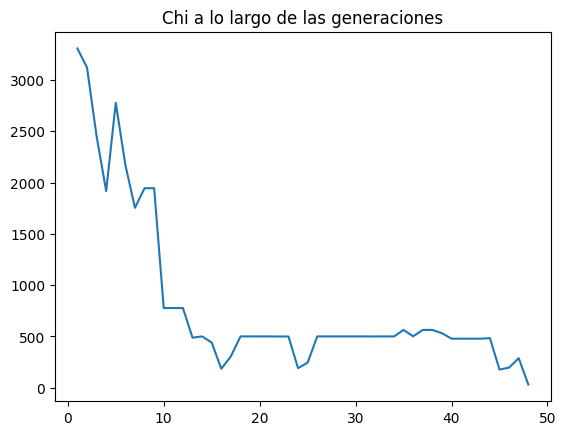

In [ ]:
Chi_menor = C[1]

Gran_Chi = np.zeros(len(C[1]))

Numero_generacion = np.zeros(len(C[1]))

i = 1
for n in range(0, len(Chi_menor)):
    Numero_generacion[n] = i
    Gran_Chi[n] = (Chi_menor[n])
    i+=1

plt.plot(Numero_generacion, Gran_Chi)
plt.title('Chi a lo largo de las generaciones')

In [ ]:
def f1(x):
    return ((36) + ((6) * ((((((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))))) - (((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))))) * ((((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))))) - (((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))))))) + (6)))) + ((((6) + (((((((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) + (((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))) - (((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))))) + ((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))))) - ((((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))))) - ((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x))))))) - ((((((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) + (((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))) - (((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))))) + ((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))))) * ((((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))))) - ((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x))))))))) - x) - (((((((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x))))) - ((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))))) + (((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x))))) - ((((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) + (((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))) - (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * ((x)**x + x))))))) - (x)**x) + (((((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))))) - (((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))) + (((((x)**x - x) * ((x)**x + x)) + (((x)**x - x) * ((x)**x + x))) + ((((x)**x - x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x)))))) + (((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x))))) - ((((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x))) + ((((x)**x + x) * (x + (x)**x)) + (((x)**x - x) * (x + (x)**x)))) + ((((x + (x)**x) * (x + (x)**x)) + ((x + (x)**x) * (x + (x)**x))) - ((((x)**x - x) * (x + (x)**x)) - (((x)**x - x) * (x + (x)**x)))))))) + (6)))

# Con 7 iteraciones

def f2(x):
    return ((((((x + 1)**2 + 1)**2) + ((2*x + 3)**2)) - ((0.1844953631180527 * (x**x + x**x) * (x**x * x**x) + (x+1)) + ((x**x * x**x) + (x**x + x**x)))) + (((((x+1) + (x+1)) * (x + 2)) + ((2*x + 3)**2)) + ((((x+1) + x**x) * ((x+1) + x**x)) + ((x**x + (x+1)) * ((x+1) + x**x))))) - ((((2*(x + 1)**2 + 2) + (((x+1) * (x+1)) * ((x+1) + (x+1)))) + ((((x+1) * (x+1)) * ((x+1) + x**x)) + (2*x**(2*x) + 2))) - (((((x+1) - x**x) + ((x + 1)**(x + 1))) + (0.1844953631180527 * (x**x + x**x) * (x**x * x**x) + (x+1))) + ((((x+1) + x**x) + ((x + 1)**(x + 1))) + (((x+1) + (x+1)) + ((x + 1)**(x + 1))))))

# Con 20 generaciones

def f3(x):
    return ((0) + ((((((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))) - (0.8786113502149605 * ((x**x - (x+1)) + ((x + 1)**(x + 1))) + (4*x + 6) - (x+1))) + ((4*x + 8*x**x + 14) + ((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))))) - (((0.6086891918245958 ** -4*x + 4*x**x + 4*(x + 1)**(x + 1) + 2 + (x+1)) + ((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1))))) - (0.06281957227815094 * (((x**x - (x+1)) + ((x + 1)**(x + 1))) + (((x+1) + x**x) + ((x + 1)**(x + 1)))) + (4*x + 8*x**x + 14) * (x+1)))) - (((((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))) - (0.8786113502149605 * ((x**x - (x+1)) + ((x + 1)**(x + 1))) + (4*x + 6) - (x+1))) + ((4*x + 8*x**x + 14) + ((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))))) - (((4*x + 8*x**x + 14) + (4*x + 8*x**x + 14)) + (((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))) - (0.8786113502149605 * ((x**x - (x+1)) + ((x + 1)**(x + 1))) + (4*x + 6) - (x+1))))))) + (((((((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))) - (0.8786113502149605 * ((x**x - (x+1)) + ((x + 1)**(x + 1))) + (4*x + 6) - (x+1))) + ((4*x + 8*x**x + 14) + ((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))))) - (((0.6086891918245958 ** -4*x + 4*x**x + 4*(x + 1)**(x + 1) + 2 + (x+1)) + ((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1))))) - (0.06281957227815094 * (((x**x - (x+1)) + ((x + 1)**(x + 1))) + (((x+1) + x**x) + ((x + 1)**(x + 1)))) + (4*x + 8*x**x + 14) * (x+1)))) - (((((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))) - (0.8786113502149605 * ((x**x - (x+1)) + ((x + 1)**(x + 1))) + (4*x + 6) - (x+1))) + ((4*x + 8*x**x + 14) + ((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))))) - (((4*x + 8*x**x + 14) + (4*x + 8*x**x + 14)) + (((((x+1) + (x+1)) * ((x+1) + x**x)) * (((x+1) - x**x) + ((x+1) + (x+1)))) - (0.8786113502149605 * ((x**x - (x+1)) + ((x + 1)**(x + 1))) + (4*x + 6) - (x+1)))))) - (0))

# Con 7 generaciones y chi = 61

def f4(x):
    return ((((((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x)))) + (((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x))))) + ((((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))) - (((((x+1) * (x+1)) * ((x+1) * x**x)) - (((x+1) * (x+1)) + (x**x + x**x))) - (((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1))))))) - (((((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))) + ((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x))))) + (((((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))) + (((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x)))) - ((((x**x + 2)**2) + ((x**x + (x+1)) * (x**x + (x+1)))) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1)))))))) - (((((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x)))) + (((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)))) + (((((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))) + (((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x)))) - ((((x**x + 2)**2) + ((x**x + (x+1)) * (x**x + (x+1)))) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))))) - (((((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))) + ((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x))))) + (((((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))) + (((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x)))) - ((((x**x + 2)**2) + ((x**x + (x+1)) * (x**x + (x+1)))) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))))))) + (((((((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))) - (((((x+1) * (x+1)) * ((x+1) * x**x)) - (((x+1) * (x+1)) + (x**x + x**x))) - (((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))))) + ((((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2))) + ((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + (((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1))))))) - ((((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x)))) + (((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)))) + (((((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))) + (((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x)))) - ((((x**x + 2)**2) + ((x**x + (x+1)) * (x**x + (x+1)))) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1)))))))) + ((((((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1))))) - (((((x+1) * (x+1)) * ((x+1) * x**x)) - (((x+1) * (x+1)) + (x**x + x**x))) - (((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))))) + ((((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2))) + ((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + (((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1))))))) - ((((((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x))) + ((((x+1) + x**x) * (x**x + 1)) + (((x+1) * (x+1)) + (x**x + x**x)))) + (((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)) + ((((x+1) + x**x) * (x**x + 1)) + ((x**x + 2)**2)))) + (((((x**x + 2)**2) + (((x+1) + x**x) + ((x+1) * (x+1)))) + (((x**x + 1) + ((x+1) * (x+1))) + (((x+1) * (x+1)) + (x**x + x**x)))) - ((((x**x + 2)**2) + ((x**x + (x+1)) * (x**x + (x+1)))) + ((((x+1) * (x+1)) + (x**x + x**x)) + ((x**x + 1) + ((x+1) * (x+1)))))))))

# Con 47 generaciones y chi = 32.07

def f5(x):
    return ((0.41239682448933457 ** (((76.585445374754699) + (73.584769190628599)) - (73.584769190628599)) + (0.06073863458985951 ** (84.179049624981539) + (73.584769190628599) * (x+1)) + x**x) - (73.584769190628599)) + (54.940352573236782)

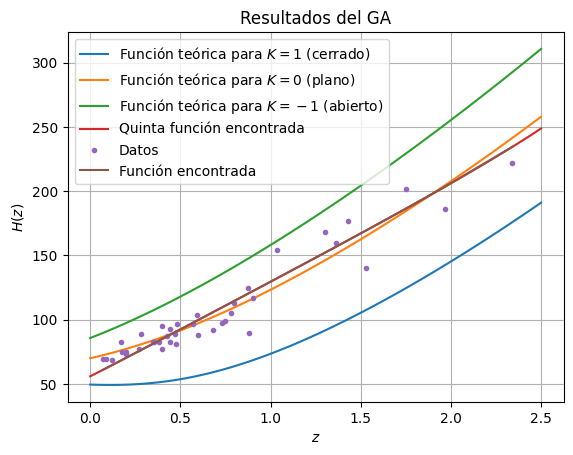

In [ ]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE, Omega_0): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_0)*(1+z)**2))

H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[1])
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[2])
H_teorico_abierto = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[0])

plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Función teórica para $K = 0$ (plano)')
plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')
#plt.plot(z_bu, f1(z_bu), label = 'Primera función encontrada')
#plt.plot(z_bu, f2(z_bu), label = 'Segunda función encontrada')
#plt.plot(z_bu, f3(z_bu), label = 'Tercera función encontrada')
#plt.plot(z_bu, f4(z_bu), label = 'Tercera función encontrada')
plt.plot(z_bu, f5(z_bu), label = 'Quinta función encontrada')


plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.grid(True)
plt.show()

### Lo que siguen son borradores! 

Falta implementar el proceso de mutacion que sugirió el profe

In [ ]:
A = GA(num_poblacion_inicial=5, poblacion_base = ['x', '(x)**x'], operaciones_base = ['*', '+', '-', '/', 'comp'])

In [ ]:
intento1 = A.Iteracion(5, 20, 10, z, H, desv, 6)

# 5 generaciones = 3s

AttributeError: 'GA' object has no attribute 'Iteracion'

In [ ]:
Chi = np.zeros(len(intento1[0]))
x = symbols('x')
expresiones_sympy = [sympify(exp) for exp in intento1[0]]

funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
valores_x_np = np.array(z)
H_np = np.array(H)
desv_np = np.array(desv)

for n, funcion_evaluada in enumerate(funciones_evaluadas):
    f = funcion_evaluada(valores_x_np)
    diferencia = (H_np - f)
    chi = np.sum((diferencia/desv_np)**2)
    Chi[n] = chi
seleccion = min(Chi)
seleccionados = Chi[Chi == seleccion]
indices = np.where(Chi == seleccion)[0]
funciones_seleccionadas = [intento1[0][i] for i in indices]

print(funciones_seleccionadas)
print(len(funciones_seleccionadas))

funcion = lambdify(x, funciones_seleccionadas[0], 'numpy')

evaluada = funcion(z)

[2*x**2 + 2*x + 4*x**(2*x)]
1


Text(0.5, 1.0, 'Chi a lo largo de las generaciones')

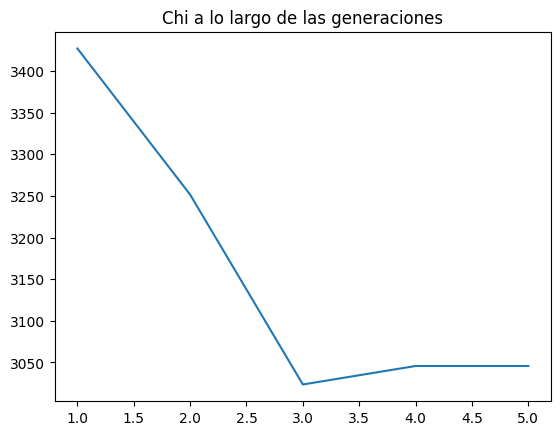

In [ ]:
Chi_menor = intento1[1]

Gran_Chi = np.zeros(len(intento1[1]))

Numero_generacion = np.zeros(len(intento1[1]))

i = 1
for n in range(0, len(Chi_menor)):
    Numero_generacion[n] = i
    Gran_Chi[n] = (Chi_menor[n])
    i+=1

plt.plot(Numero_generacion, Gran_Chi)
plt.title('Chi a lo largo de las generaciones')

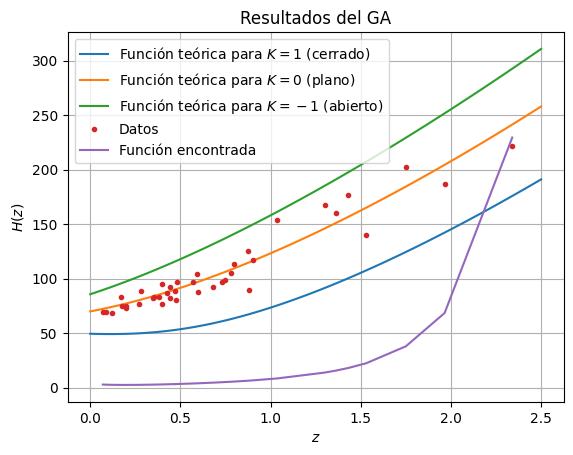

In [ ]:
def H_bm(z, Omega_r, Omega_m, Omega_lambda, omega_DE, Omega_0): 
    return H_0*np.sqrt((Omega_r*(1+z)**(3*(1 + 1/3)) + Omega_m*(1+z)**3 + Omega_lambda*(1+z)**(3*(1+omega_DE)) + (1-Omega_0)*(1+z)**2))

H_0 = 70
O_r = 8.4*10**(-5)
O_m = 0.3
O_lambda = 0.7 - 8.4*10**(-5)
o_DE = -1
O_0 = [0.5, 1, 1.5]

# Se crea un arreglo de z para la función teórica
z_bu = np.linspace(0, 2.5, 100)

# hub_data_3.txt
H_teorico_plano = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[1])
H_teorico_cerrado = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[2])
H_teorico_abierto = H_bm(z_bu,O_r, O_m, O_lambda, o_DE, O_0[0])

plt.plot(z_bu, H_teorico_cerrado, label = 'Función teórica para $K = 1$ (cerrado)')
plt.plot(z_bu, H_teorico_plano, label = 'Función teórica para $K = 0$ (plano)')
plt.plot(z_bu, H_teorico_abierto, label = 'Función teórica para $K = -1$ (abierto)')


plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.grid(True)
plt.show()